In [ ]:
import cv2
import numpy as np
import scipy.ndimage
from matplotlib import pyplot as plt
from skimage.transform import resize
from scipy import io

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split


In [ ]:
path = '/content/drive/MyDrive/deepleaninghw1data/moving_target_dataset.npy'
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = np.load(path, allow_pickle=True)

print(data)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
input_images = []
target_images = []

ksize=3
class_names = ["uav","bicycle","person","vehicle"]
scale_factor = 2
temp_images = []

i=0

for signature in data:
    for class_name in class_names:
        if (len(signature['snr_db']) > 20 and signature['class_name']==class_name):

            arr1 = signature['signature']
            #print(arr1.shape)
            temp_images.append(np.abs(np.fft.fft(arr1, axis=0)))
            arr2 = np.abs(arr1).transpose()
            arr2 = cv2.resize(arr2, (40, 1008))

            #arr2 =  20 * np.log10(np.abs(arr1)).transpose()
            interp_times = 1
            #res = resize(arr2, (arr2.shape[0]/scale_factor , arr2.shape[1]))

            #arr = res
            blurred_image = arr2

            arr2 = np.abs(np.fft.fft(arr2, axis = 1))
            blurred_image = 20*np.log10(np.abs(np.fft.fft(arr2, axis = 1)))
            blurred_image = resize(blurred_image, (arr2.shape[0]/scale_factor , arr2.shape[1]))
            '''
            prf = signature['radar_parameters']['prf']
            plt.imshow(blurred_image, cmap='jet', aspect='auto'
                          )
            plt.show()
            plt.title(signature['class_name'])
            plt.autoscale()

            plt.xlabel('Time (seconds)')
            plt.ylabel('range')

            plt.title("blurred_image")
            plt.autoscale()

            plt.xlabel('Time (seconds)')
            plt.ylabel('range (Hz)')
            #plt.show()
            '''

            #blurred_images.append(blurred_image)
            #original_image.append(arr)
            arr3 = 20*np.log10(arr2)
            input_images.append(blurred_image[np.newaxis,:].astype(np.float32))
            target_images.append(arr3[np.newaxis,:].astype(np.float32))


In [ ]:
print(len(input_images))
print(input_images[0].shape)
print(len(target_images))
print(target_images[0].shape)

341
(1, 504, 40)
341
(1, 1008, 40)


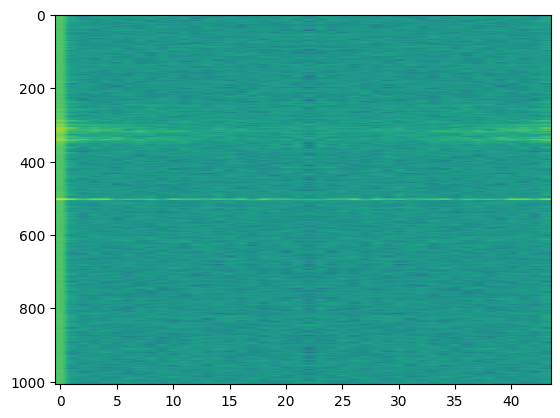

(1008, 44)


In [ ]:
for image in temp_images:
    tt = 20*np.log10(np.abs(np.fft.fft(image, axis=0))).transpose()
    plt.imshow(tt, aspect='auto')
    plt.show()
    print(tt.shape)
    break

In [ ]:
class MyDataset(Dataset):
    def __init__(self, input_images, target_images):
        self.input_images = input_images
        self.target_images = target_images

    def __getitem__(self, index):
        input_image = self.input_images[index]
        target_image = self.target_images[index]
        max = np.max(target_image)
        min = np.min(target_image) + 10e-3
        # normalization

        input_image = (input_image - min) / (max - min)
        target_image = (target_image - min) / (max - min)

        return input_image, target_image

    def __len__(self):
        return len(self.input_images)

train_images, test_images, train_targets, test_targets = train_test_split(input_images, target_images, test_size=0.2, random_state=42)

train_dataset = MyDataset(train_images, train_targets)
test_dataset = MyDataset(test_images, test_targets)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
print(train_loader)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [ ]:
import torch.nn.functional as F
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, num_filters):
        super(UNet, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, num_filters, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_filters),
            nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_filters),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.middle = nn.Sequential(
            nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_filters),
            nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_filters),
            nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_filters)
        )

        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(num_filters, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),

        )

    def forward(self, x):
        x = self.encoder(x)
        for i in range(1):
            x = self.middle(x)
        x = self.decoder(x)
        return x

class SRCNN(nn.Module):
    def __init__(self, num_channels=1):
        super(SRCNN, self).__init__()
        self.Up =  nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.conv1 = nn.Conv2d(num_channels, 32, kernel_size=9, padding=9 // 2)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=5, padding=5 // 2)
        self.conv3 = nn.Conv2d(16, num_channels, kernel_size=5, padding=5 // 2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = F.interpolate(x, size=[1008, 40], mode='bilinear')
        #x = self.Up(x)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)

        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
in_channels = 1
out_channels = 1
num_filters = 32

#net = UNet(in_channels, out_channels, num_filters)
net = SRCNN()
net = net.to(device)


loss_fn = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=3*10e-4)
num_epochs = 20

loss_list=np.zeros((2,num_epochs))


for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0

    for inputs, targets in train_loader:

        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = net(inputs)

        loss = loss_fn(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    net.eval()

    with torch.no_grad():
        test_loss = 0.0

        for inputs, targets in test_loader:

            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = net(inputs)
            loss = loss_fn(outputs, targets)

            test_loss += loss.item()

        avg_test_loss = test_loss / len(test_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss}, Test Loss: {avg_test_loss}")
    loss_list[0, epoch] = avg_train_loss
    loss_list[1, epoch] = avg_test_loss

Epoch 1/20, Train Loss: 0.01374366189360016, Test Loss: 0.005768957382499956
Epoch 2/20, Train Loss: 0.007935425022664918, Test Loss: 0.005726897407431102
Epoch 3/20, Train Loss: 0.007553406202693141, Test Loss: 0.011689811546787403
Epoch 4/20, Train Loss: 0.007746066443574177, Test Loss: 0.005657407563125742
Epoch 5/20, Train Loss: 0.007565507090047878, Test Loss: 0.0061982454144922285
Epoch 6/20, Train Loss: 0.007745584490989773, Test Loss: 0.005690426616322087
Epoch 7/20, Train Loss: 0.007017273906967603, Test Loss: 0.0053575770639261045
Epoch 8/20, Train Loss: 0.007838310609633267, Test Loss: 0.0057785030035976915
Epoch 9/20, Train Loss: 0.007362785843296853, Test Loss: 0.011833961951829817
Epoch 10/20, Train Loss: 0.007739834653501234, Test Loss: 0.005286077968776226
Epoch 11/20, Train Loss: 0.006547107069362777, Test Loss: 0.005895055854099168
Epoch 12/20, Train Loss: 0.007076022311914986, Test Loss: 0.01042476918656325
Epoch 13/20, Train Loss: 0.007188487258698682, Test Loss: 0.

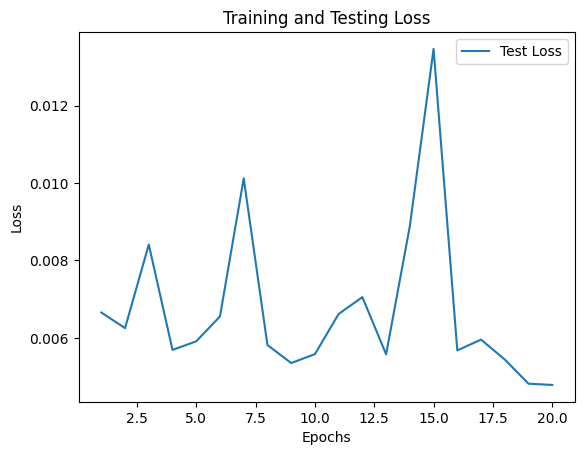

In [ ]:
plt.plot(range(1, num_epochs+1), loss_list[1], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()

In [ ]:
print(inputs.shape)
print(targets.shape)

torch.Size([1, 1, 504, 40])
torch.Size([1, 1, 1008, 40])


In [ ]:
print(torch.max(inputs),torch.min(inputs))
print(torch.max(outputs),torch.min(outputs))
print(torch.max(targets),torch.min(targets))
#print(torch.max(targets.cpu().detach())*(data_range[0]-data_range[1])+data_range[1], torch.min(targets.cpu().detach())*(data_range[0]-data_range[1])+data_range[1])

tensor(1.1030, device='cuda:0') tensor(0.6198, device='cuda:0')
tensor(0.8530, device='cuda:0') tensor(0.5472, device='cuda:0')
tensor(1., device='cuda:0') tensor(-7.7470e-05, device='cuda:0')


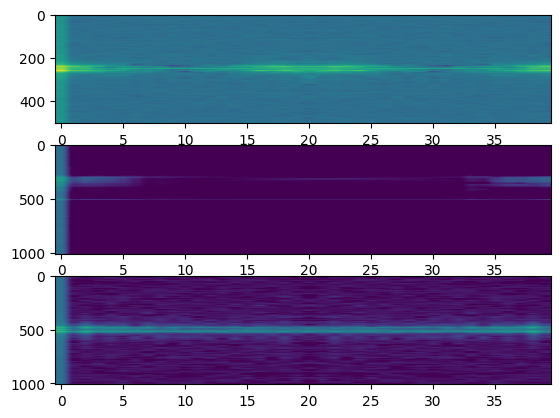

0.78557587 -4.8289647
-1.2073194 -7.2105365
0.0 -83.257256


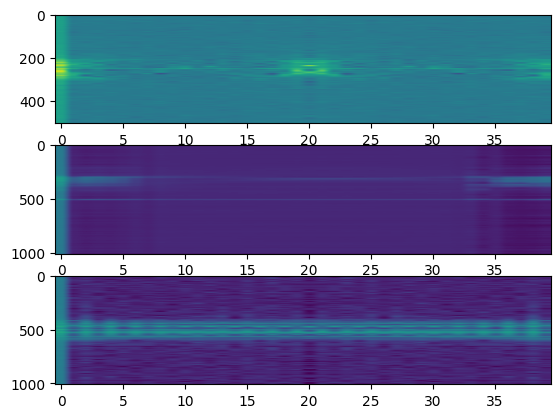

1.3862929 -6.336799
-1.2073194 -7.2105365
-5.177194e-07 -81.03046


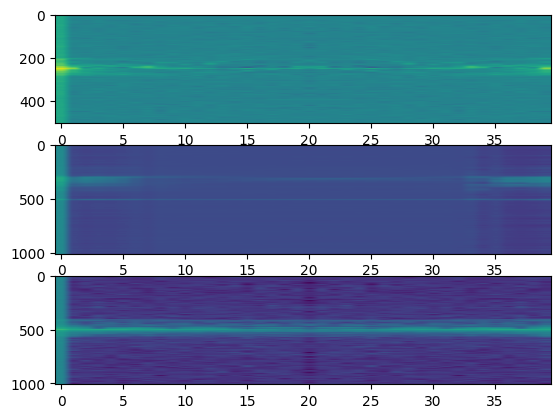

1.5086187 -8.500554
-1.2073194 -7.2105365
1.0354387e-06 -80.0397


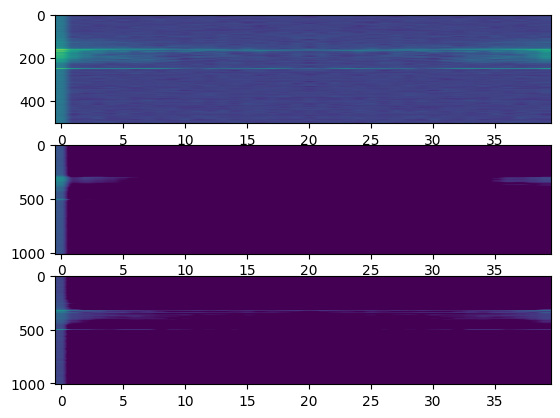

0.8375882 -3.8267221
-1.2073194 -7.2105365
0.0 -81.707985


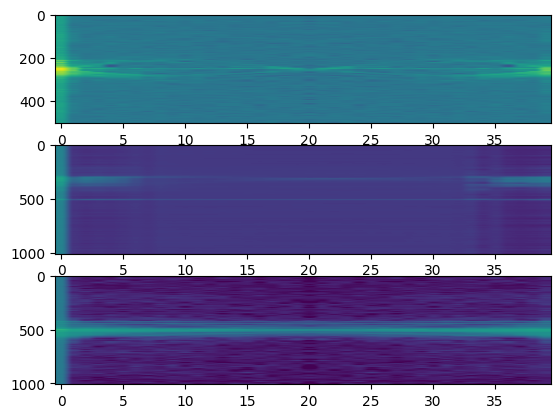

1.4046538 -7.1999693
-1.2073194 -7.2105365
1.0354387e-06 -79.89082


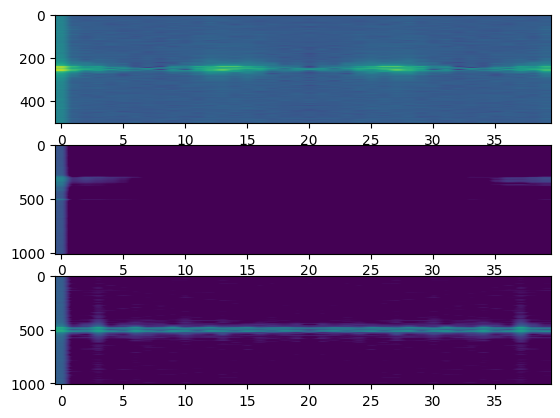

1.2270976 -4.08099
-1.2073194 -7.2105365
0.0 -83.03651


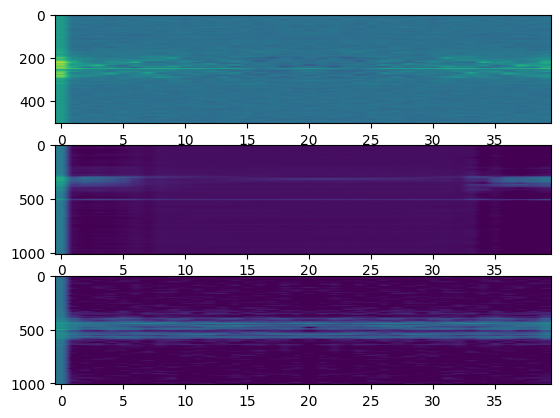

0.67523295 -5.3668327
-1.2073194 -7.2105365
0.0 -81.80786


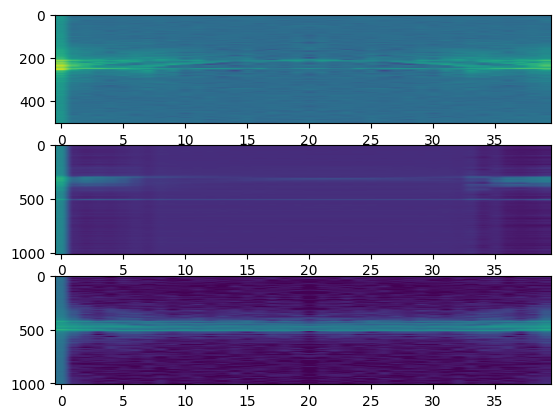

0.79917103 -6.39112
-1.2073194 -7.2105365
0.0 -81.86714


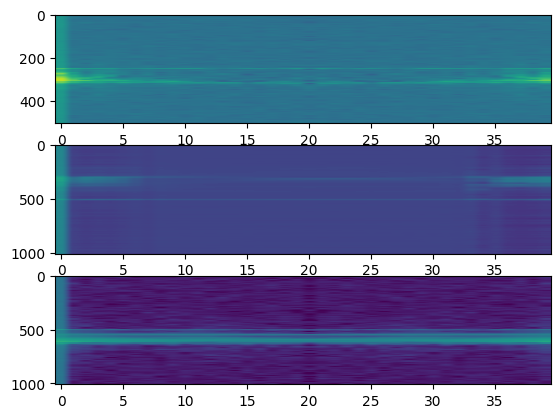

1.598596 -8.097731
-1.2073194 -7.2105365
0.0 -79.99814


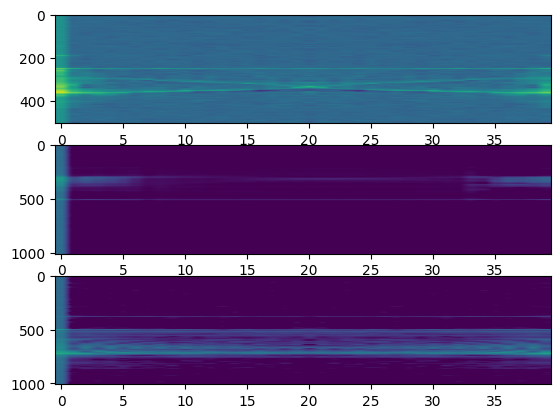

1.0490264 -5.0190916
-1.2073194 -7.2105365
0.0 -81.31416


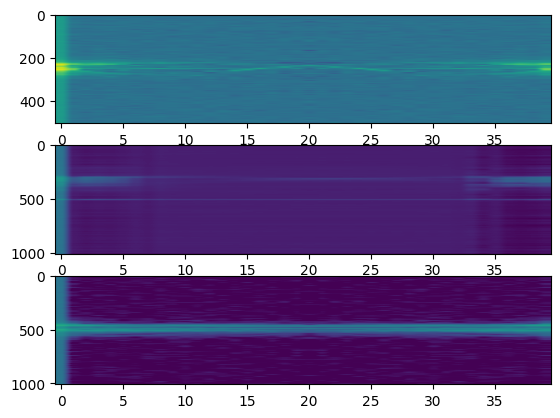

1.4592868 -5.985757
-1.2073194 -7.2105365
0.0 -79.846146


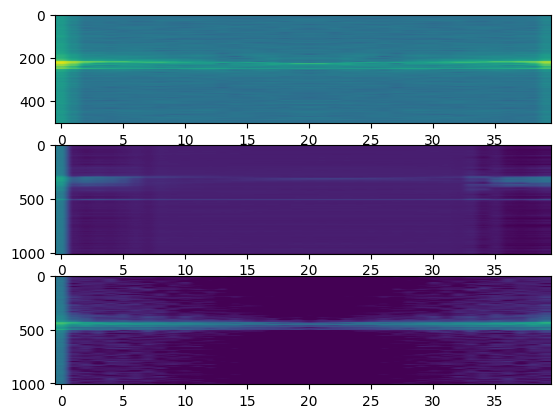

1.0145586 -5.889735
-1.2073194 -7.2105365
0.0 -81.12314


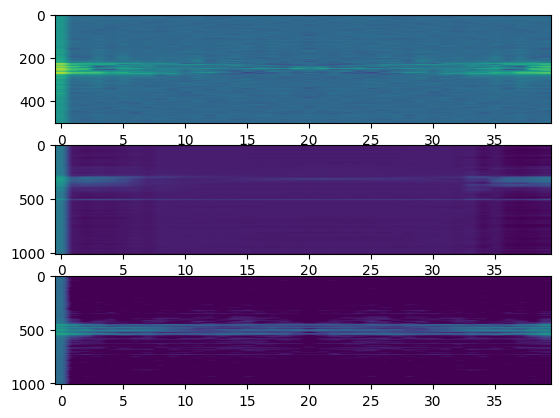

1.1570837 -5.832016
-1.2073194 -7.2105365
0.0 -80.10672


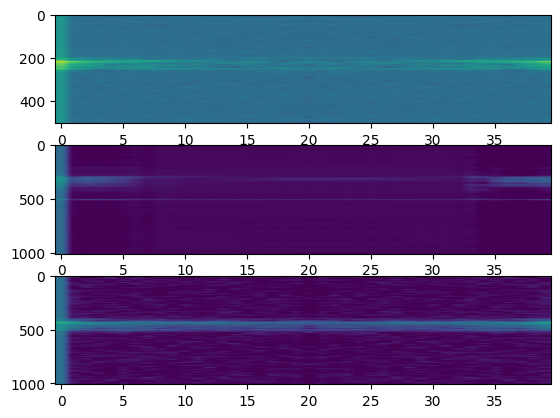

1.3344009 -5.2627845
-1.2073194 -7.2105365
0.0 -81.24191


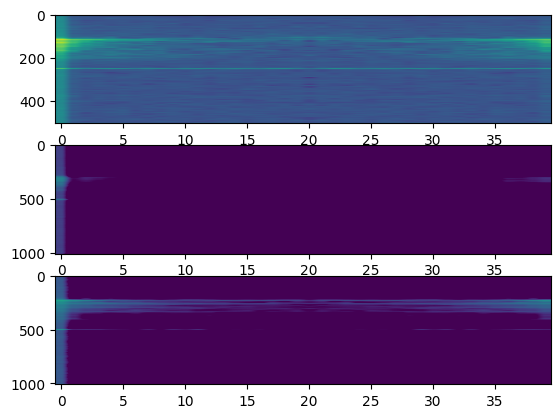

0.6694284 -3.243365
-1.2073194 -7.2105365
0.0 -82.61835


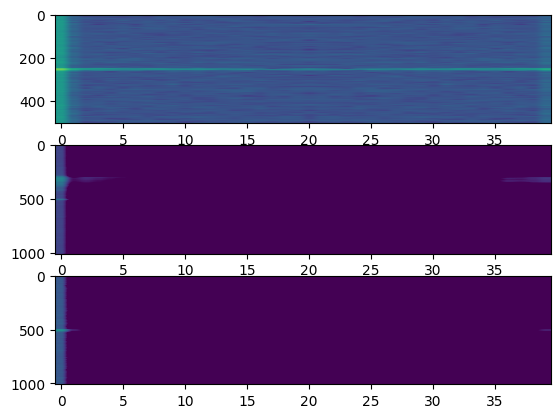

0.71594304 -3.3704875
-1.2073194 -7.2105365
0.0 -79.922585


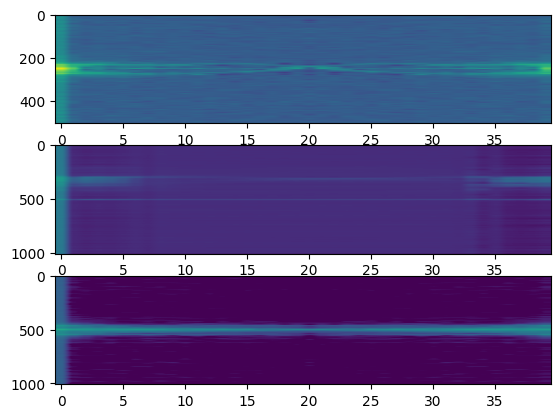

1.6215756 -6.681512
-1.2073194 -7.2105365
1.0354387e-06 -79.45361


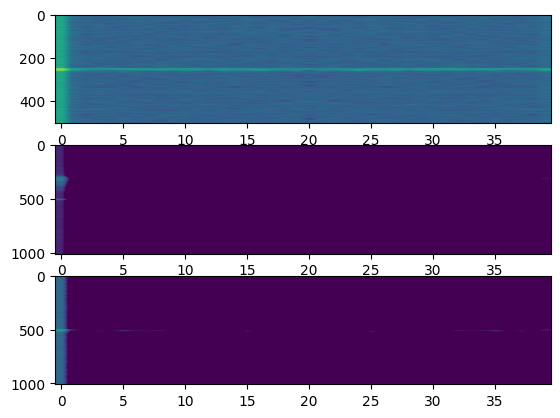

0.4543718 -2.7341616
-1.2073194 -7.2105365
0.0 -82.20566


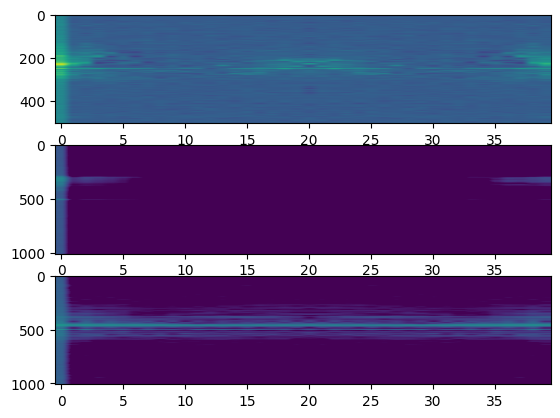

1.1431981 -4.090193
-1.2073194 -7.2105365
0.0 -82.53288


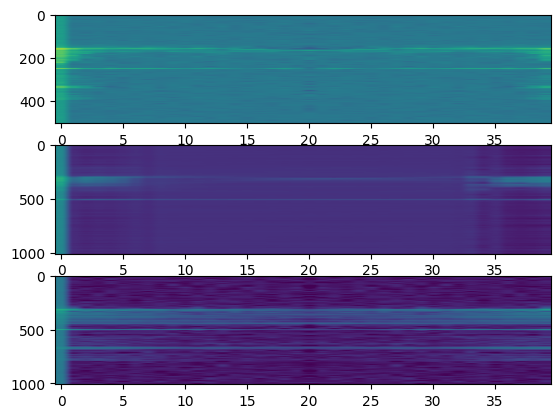

0.83721393 -6.540916
-1.2073194 -7.2105365
0.0 -81.38528


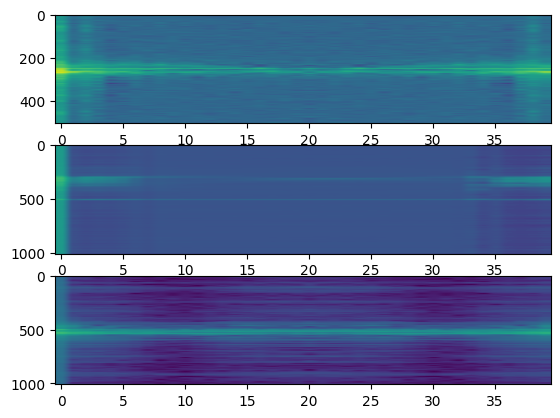

0.76883245 -8.544284
-1.2073194 -7.2105365
1.0354387e-06 -81.33078


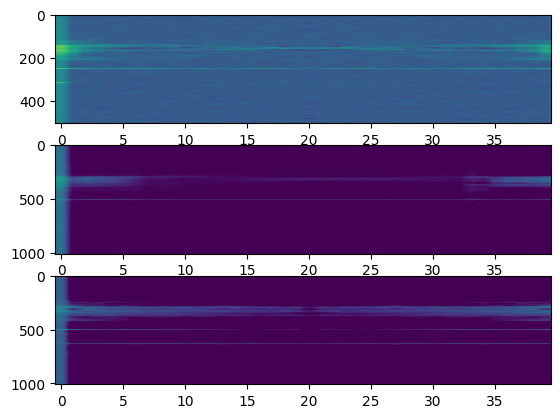

0.86827826 -5.0011797
-1.2073194 -7.2105365
0.0 -81.124435


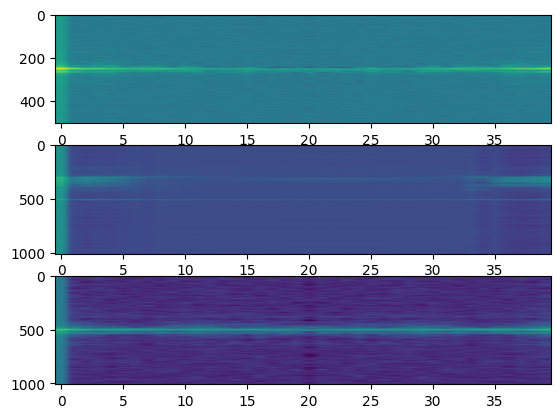

1.1473819 -8.3584795
-1.2073194 -7.2105365
0.0 -81.28087


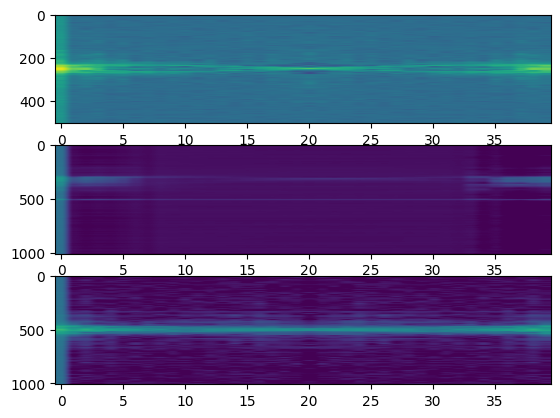

1.2377006 -5.4198527
-1.2073194 -7.2105365
0.0 -81.47249


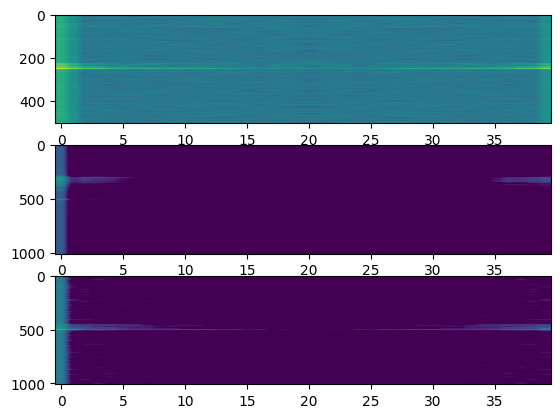

0.59030193 -3.8909457
-1.2073194 -7.2105365
0.0 -81.27732


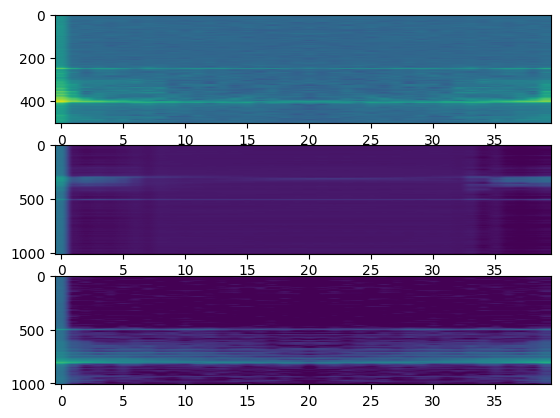

1.2991787 -5.675685
-1.2073194 -7.2105365
0.0 -80.93042


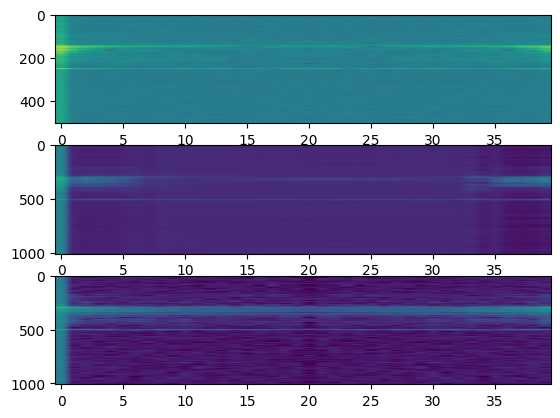

0.87799454 -6.263079
-1.2073194 -7.2105365
-5.177194e-07 -81.029144


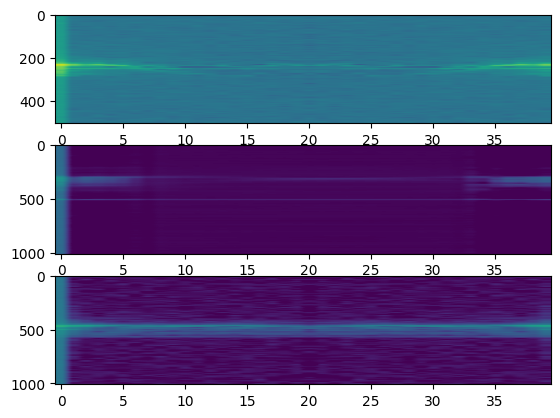

1.266963 -5.166523
-1.2073194 -7.2105365
0.0 -81.33167


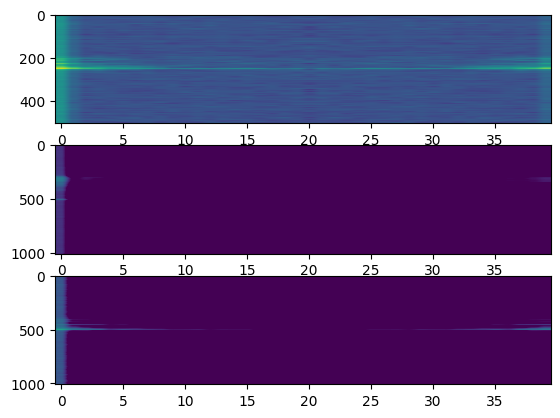

0.7188623 -3.013203
-1.2073194 -7.2105365
-5.177194e-07 -81.24084


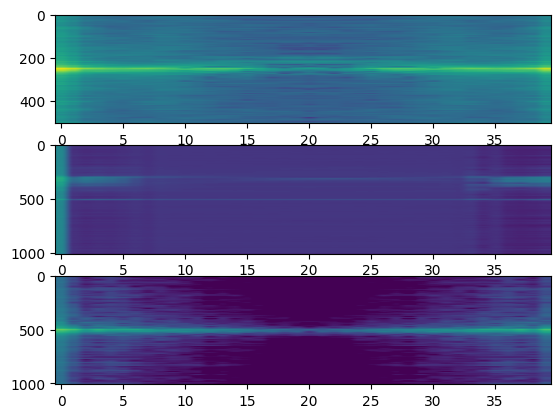

1.0200504 -6.854829
-1.2073194 -7.2105365
0.0 -81.643875


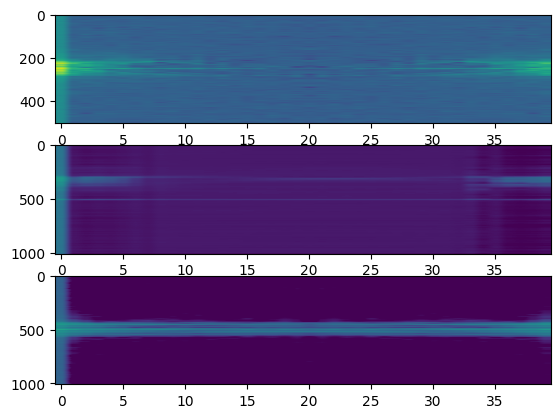

1.267108 -5.75691
-1.2073194 -7.2105365
0.0 -80.22177


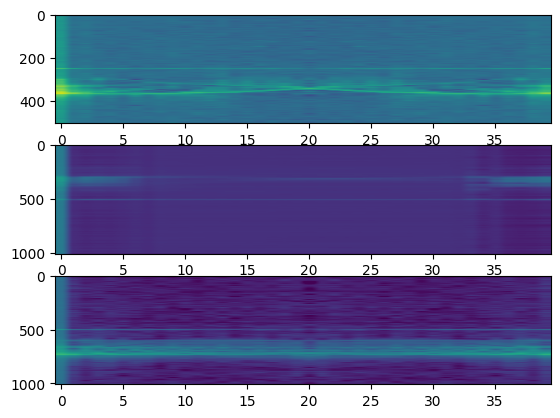

1.5978725 -6.84335
-1.2073194 -7.2105365
0.0 -80.667915


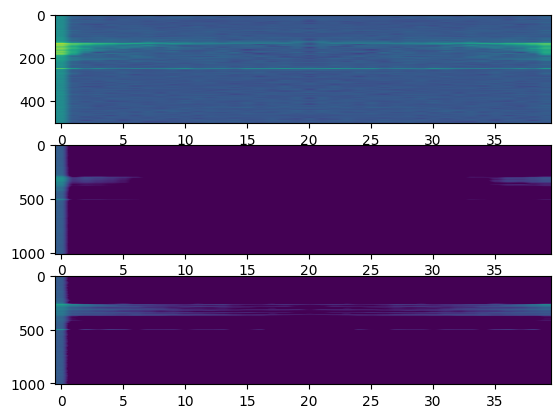

0.82394093 -4.127576
-1.2073194 -7.2105365
0.0 -80.72326


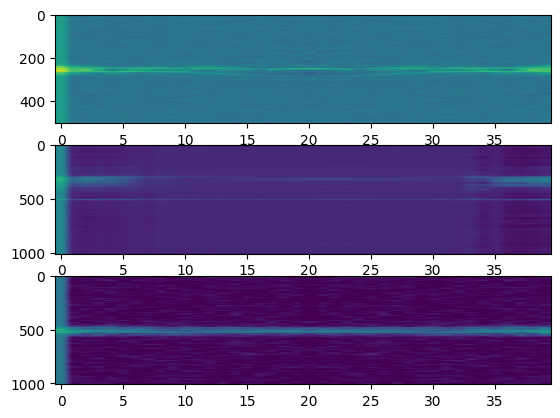

0.6988192 -6.1595893
-1.2073194 -7.2105365
0.0 -81.04306


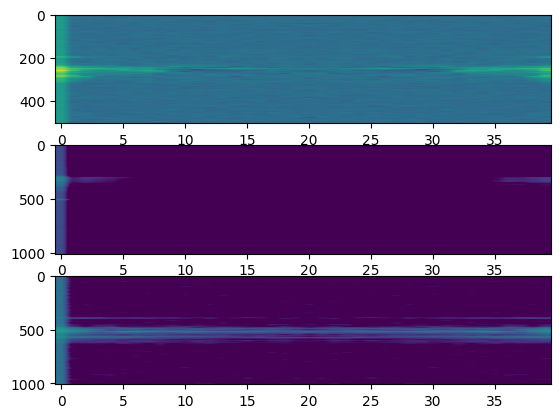

1.0462703 -3.715615
-1.2073194 -7.2105365
0.0 -82.34832


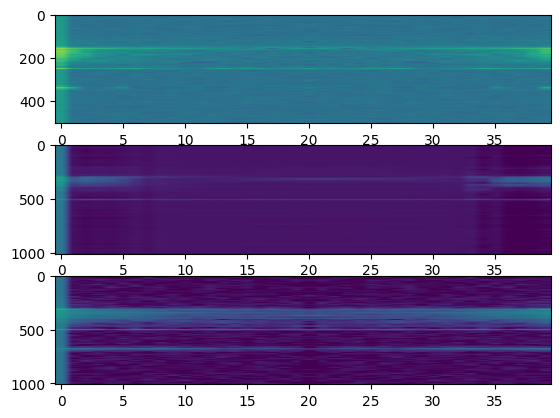

1.010538 -5.6035132
-1.2073194 -7.2105365
0.0 -81.46849


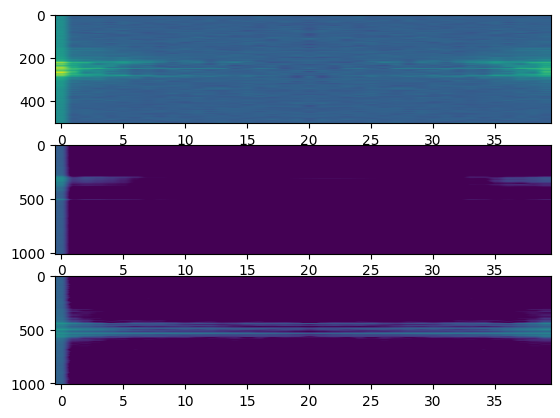

1.113231 -4.3431435
-1.2073194 -7.2105365
0.0 -81.054695


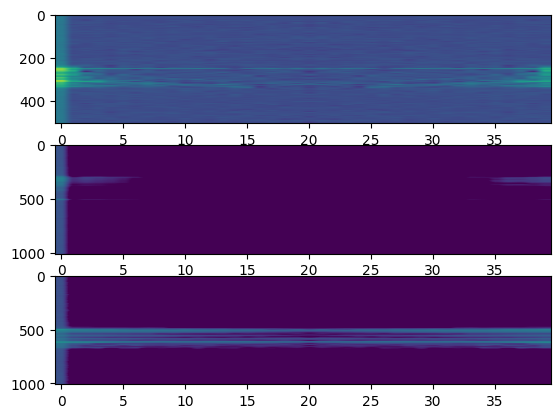

1.3551292 -4.114854
-1.2073194 -7.2105365
0.0 -81.857956


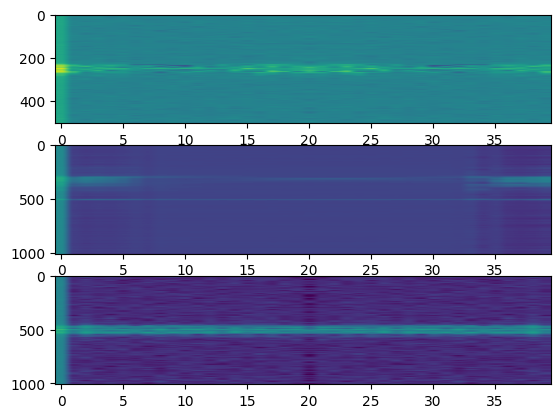

1.2642117 -7.7268333
-1.2073194 -7.2105365
-5.177194e-07 -80.37151


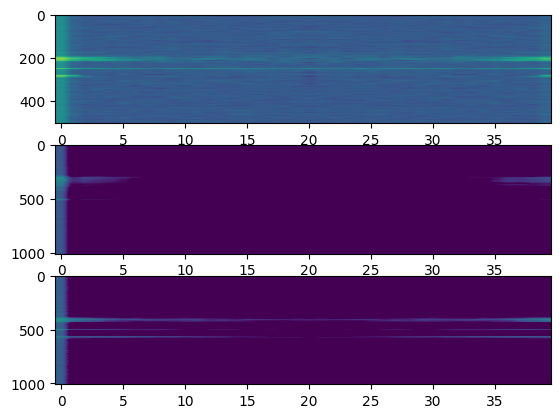

0.93822217 -3.9795196
-1.2073194 -7.2105365
0.0 -80.970116


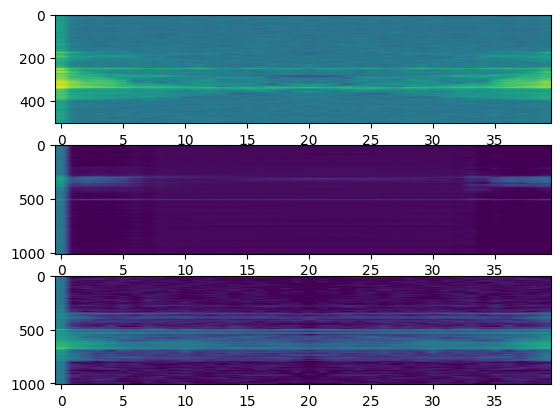

0.80968744 -5.2649555
-1.2073194 -7.2105365
0.0 -81.89991


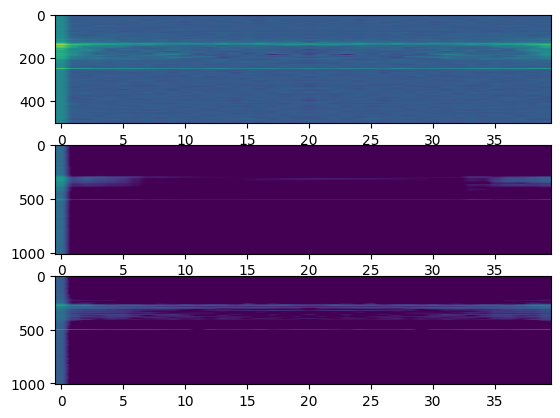

0.853112 -4.765133
-1.2073194 -7.2105365
0.0 -81.47853


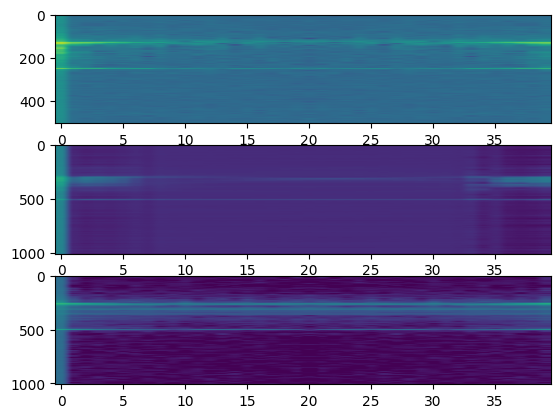

0.88973856 -6.3582764
-1.2073194 -7.2105365
0.0 -81.81096


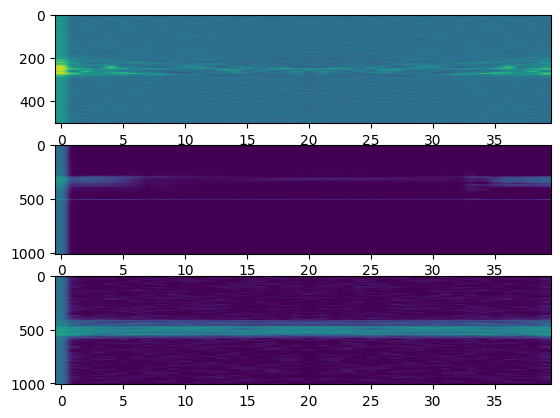

0.94301575 -4.9919457
-1.2073194 -7.2105365
0.0 -82.24005


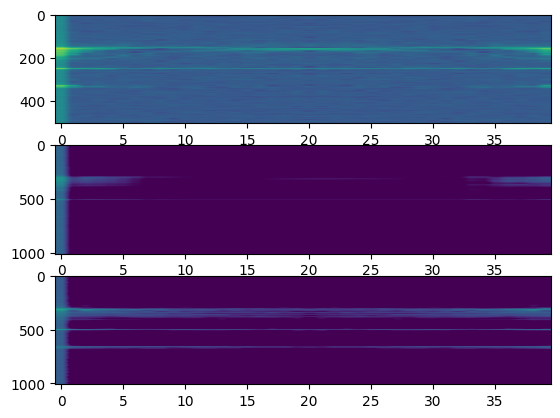

1.0166072 -4.595955
-1.2073194 -7.2105365
0.0 -80.94832


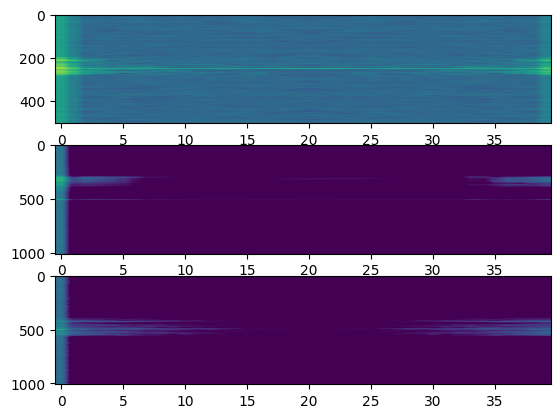

0.1557825 -4.485475
-1.2073194 -7.2105365
0.0 -81.28641


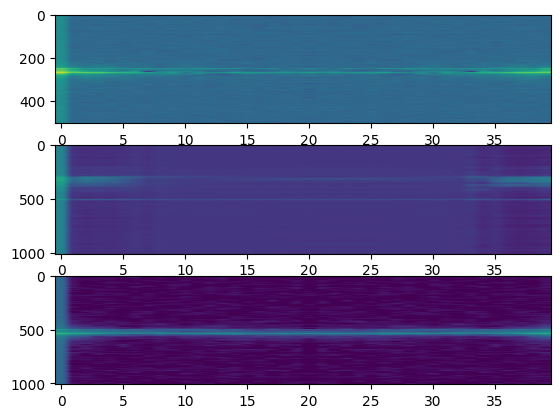

1.251133 -7.0068874
-1.2073194 -7.2105365
0.0 -80.63605


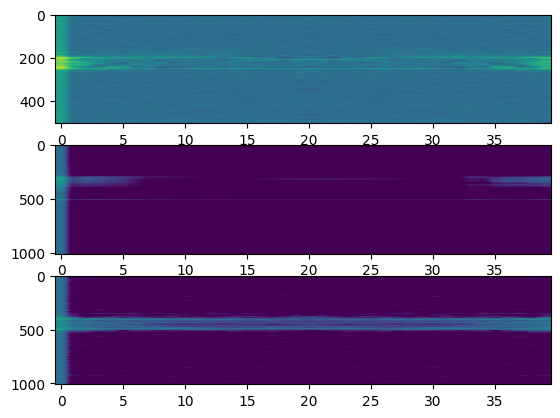

0.72028244 -4.6958165
-1.2073194 -7.2105365
0.0 -81.69669


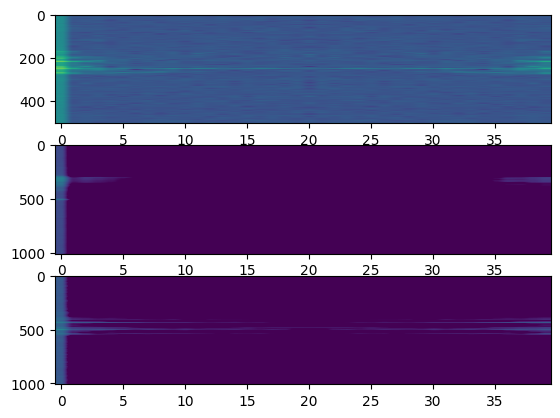

1.1152455 -3.6779904
-1.2073194 -7.2105365
-5.177194e-07 -80.5917


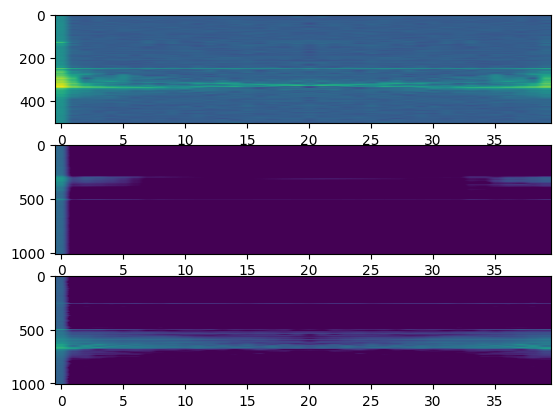

0.8813555 -4.6315603
-1.2073194 -7.2105365
0.0 -81.1919


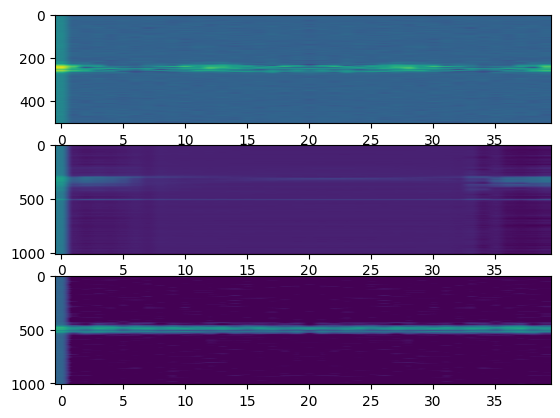

1.1690133 -6.014211
-1.2073194 -7.2105365
0.0 -81.49659


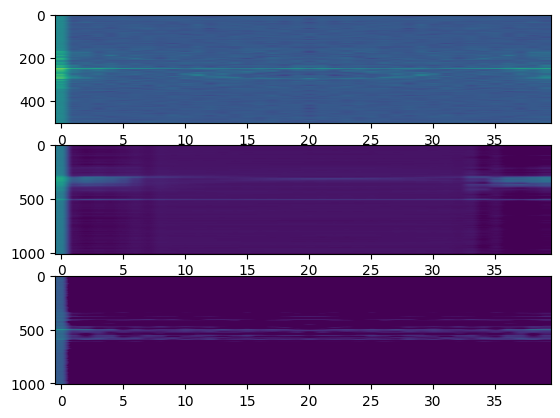

0.7779438 -5.5179586
-1.2073194 -7.2105365
0.0 -80.257965


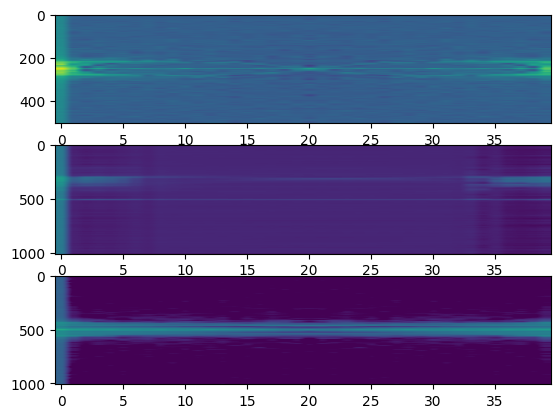

1.3897831 -6.288502
-1.2073194 -7.2105365
0.0 -80.31276


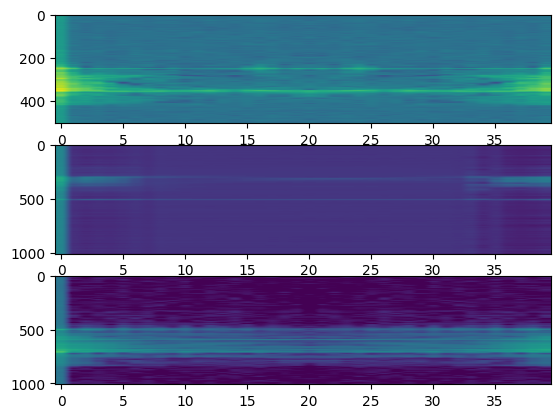

1.0591311 -6.805468
-1.2073194 -7.2105365
0.0 -80.3369


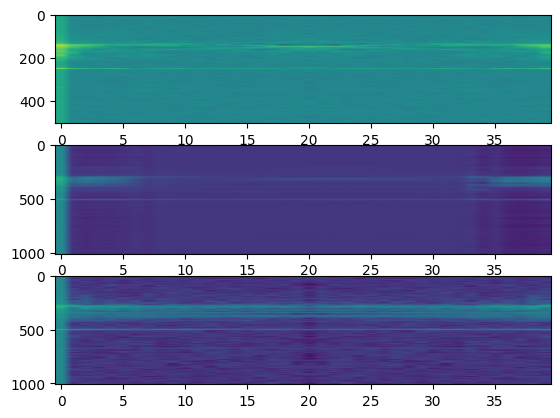

0.8623239 -6.794506
-1.2073194 -7.2105365
0.0 -82.09804


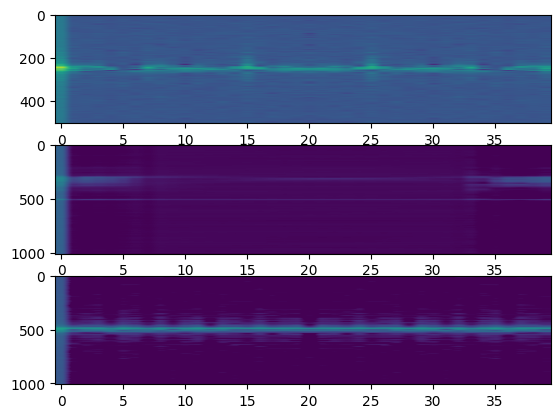

1.8484652 -5.253322
-1.2073194 -7.2105365
0.0 -81.49268


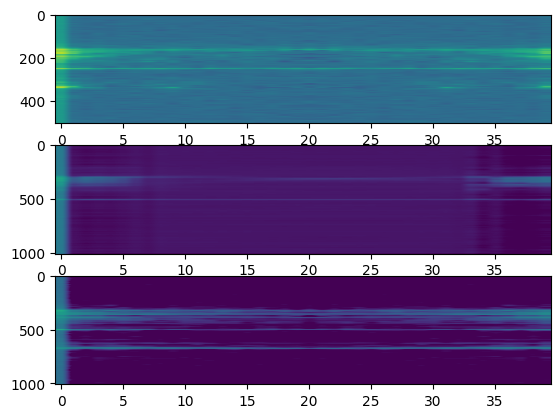

0.8842543 -5.6004934
-1.2073194 -7.2105365
0.0 -80.33362


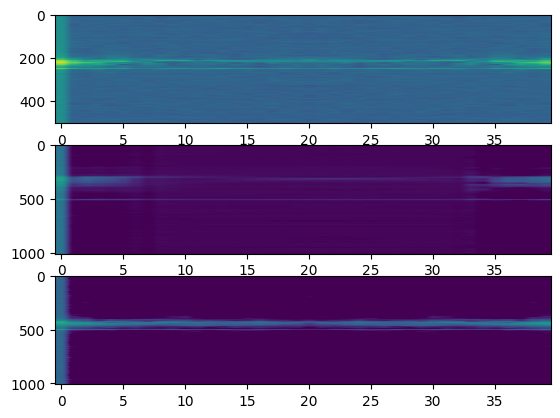

0.81673086 -5.1943684
-1.2073194 -7.2105365
0.0 -81.25786


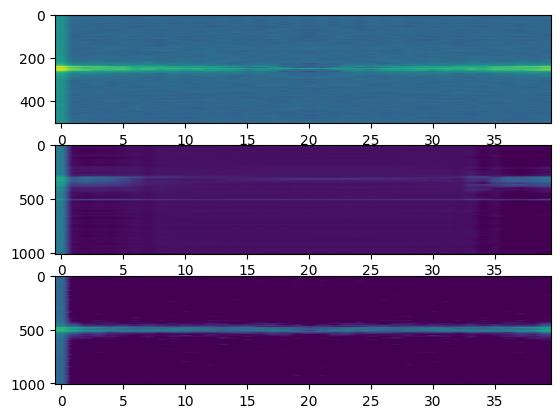

0.71447074 -5.436756
-1.2073194 -7.2105365
0.0 -81.499405


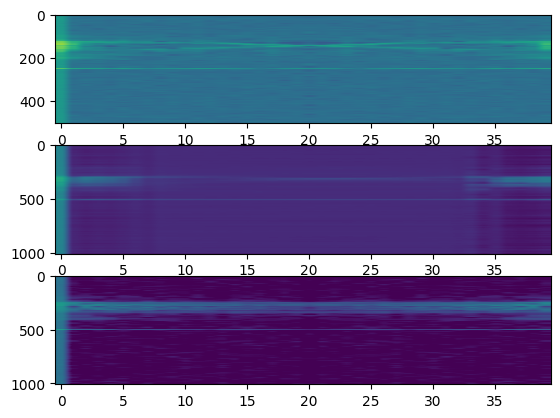

0.899302 -6.3200407
-1.2073194 -7.2105365
0.0 -80.698166


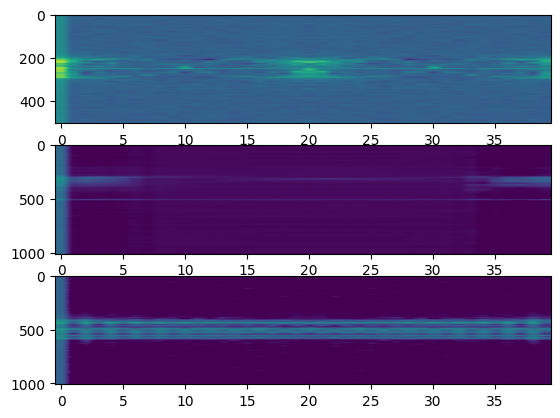

1.4119827 -5.2655625
-1.2073194 -7.2105365
0.0 -80.84777


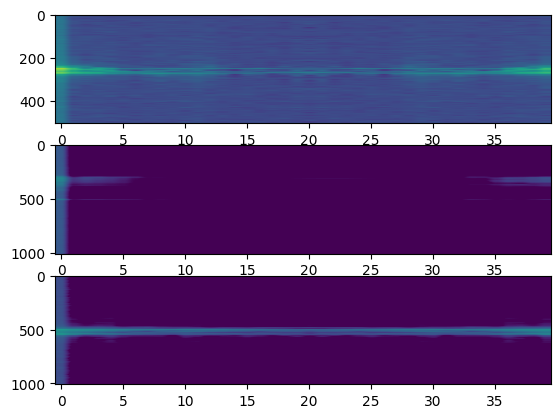

1.3411913 -4.334176
-1.2073194 -7.2105365
0.0 -82.281525


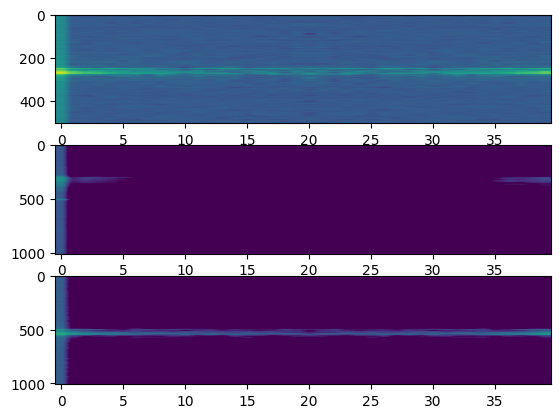

0.6064832 -3.7730274
-1.2073194 -7.2105365
0.0 -82.68337


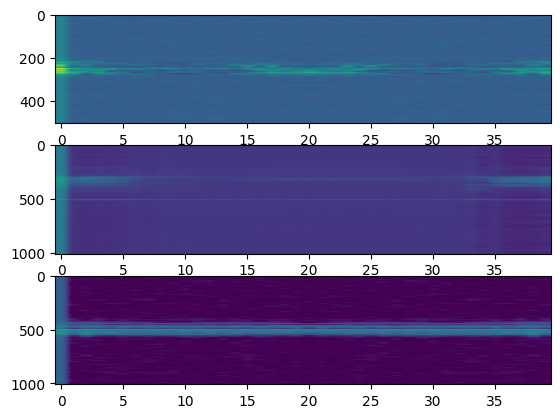

1.7891812 -7.3035975
-1.2073194 -7.2105365
-5.177194e-07 -80.236824


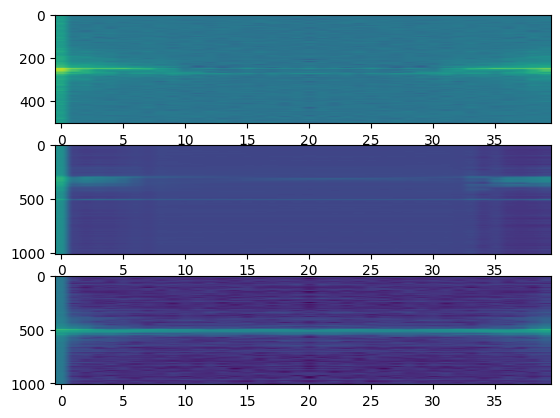

1.0057511 -7.7534714
-1.2073194 -7.2105365
0.0 -81.57466


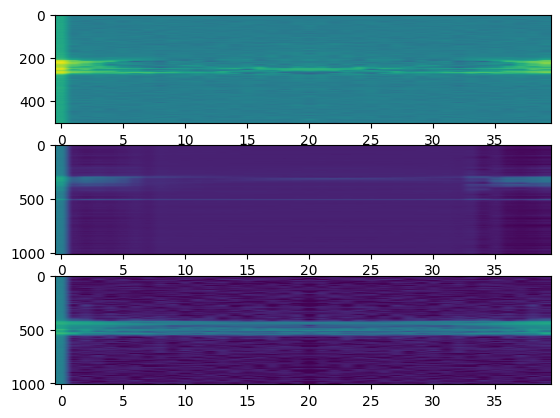

0.936709 -5.9634094
-1.2073194 -7.2105365
0.0 -80.797424


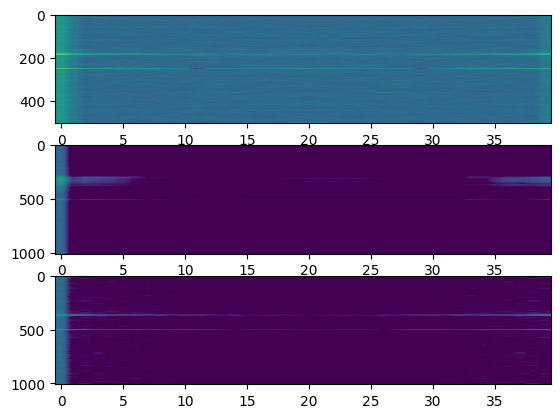

0.6962603 -4.424414
-1.2073194 -7.2105365
0.0 -82.06857


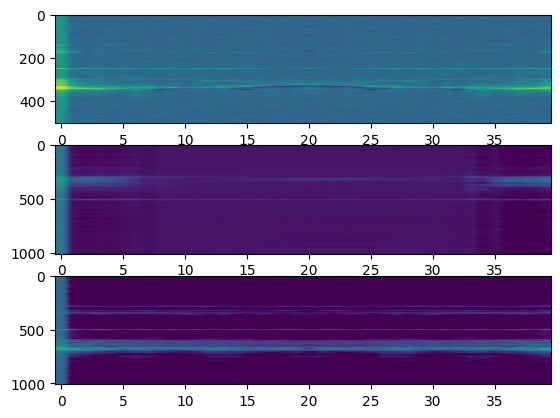

1.0140499 -5.569208
-1.2073194 -7.2105365
0.0 -80.47987


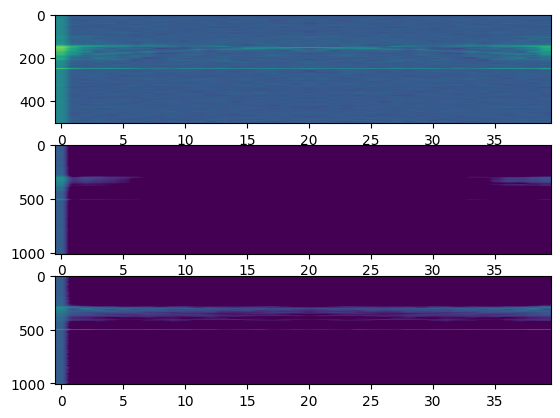

0.8515482 -4.1553283
-1.2073194 -7.2105365
0.0 -82.21729


In [ ]:
up = nn.Upsample(scale_factor = 1, mode='bilinear')

with torch.no_grad():
        test_loss = 0.0
        i = 0
        for inputs, targets in test_loader:
            #if i == 19:
            inputs = inputs.to(device)
            targets = targets.to(device)

            #outputs = unet(inputs)
            data_max = np.max(np.abs(inputs.cpu().detach().numpy()[0,0]))
            data_min = np.min(np.abs(inputs.cpu().detach().numpy()[0,0]))

            plt.subplot(3,1,1)
            plt.imshow(np.abs(up(inputs).cpu().detach().numpy()[0,0]), vmax = data_max, vmin = data_min, aspect='auto')
            plt.subplot(3,1,2)
            plt.imshow(np.abs(outputs.cpu().detach().numpy()[0,0]), vmax = data_max, vmin = data_min, aspect='auto')
            plt.subplot(3,1,3)
            plt.imshow(np.abs(targets.cpu().detach().numpy()[0,0]), vmax = data_max, vmin = data_min, aspect='auto')
            plt.show()
            print(np.max(20*np.log10(np.abs(inputs.cpu().detach().numpy()[0,0]))),np.min(20*np.log10(np.abs(inputs.cpu().detach().numpy()[0,0]))))
            print(np.max(20*np.log10(np.abs(outputs.cpu().detach().numpy()[0,0]))),np.min(20*np.log10(np.abs(outputs.cpu().detach().numpy()[0,0]))))
            print(np.max(20*np.log10(np.abs(targets.cpu().detach().numpy()[0,0]))),np.min(20*np.log10(np.abs(targets.cpu().detach().numpy()[0,0]))))
            #print(l2loss(np.abs(outputs.cpu()),np.abs(targets.cpu())))
            """
            elif i > 19:
                break
            i += 1
            """

In [ ]:
plot1.shape

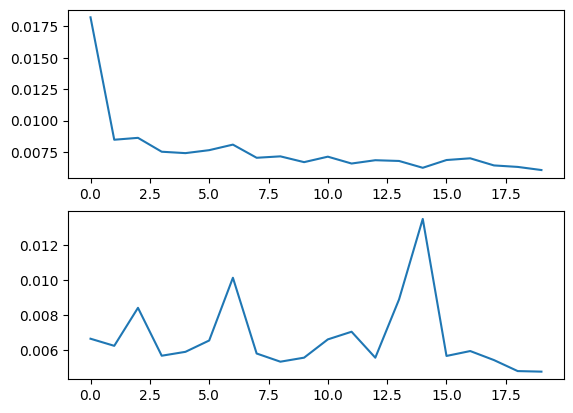

In [ ]:
plt.subplot(2,1,1)
plt.plot(loss_list[0])
plt.subplot(2,1,2)
plt.plot(loss_list[1])